<h1 align="center">PNICER demonstration notebook</h1> 


# Preparations

In [ ]:
from pnicer import ApparentMagnitudes
from pnicer.utils.auxiliary import get_resource_path

%matplotlib inline

The easiest way to initialize PNICER is to simply point it to catalog files in FITS format. The package includes a set of test resources which can be loaded with the *get_resource_path* method that was imported above. **PNICER** uses a set of measured intrinsic magnitudes (or colors) in an extinction-free control field to de-redden an extincted science field. In our test case we use the Orion A molecular cloud as science field and another field a few degrees away for our control field.

In [6]:
# ----------------------------------------------------------------------
# Find the test files included in the package
science_path = get_resource_path(package="pnicer.tests_resources", resource="Orion_A_2mass.fits")
control_path = get_resource_path(package="pnicer.tests_resources", resource="CF_2mass.fits")

Of course, you can also specify any valid path in your file system that points to a FITS catalog file. Something like the following will do the job for you.

science_path = "/path/to/science.fits"

control_path = "/path/to/control.fits"



### PNICER data setup
Now we specify the parameters for PNICER. We need to know the column names in the FITS file for both the magnitudes and the errors. In our case this is J/H/Ks from 2MASS. In addition, we also need to define the extinction law for these bands.

In [7]:
# ----------------------------------------------------------------------
# Define feature names and extinction vector
mag_names = ["Jmag", "Hmag", "Kmag"]
err_names = ["e_Jmag", "e_Hmag", "e_Kmag"]
extvec = [2.5, 1.55, 1.0]  # Indebetouw et al. 2015

# PNICER Initialization

Data can be initialized as a *ApparentMagnitudes* instance. Alternativley also a *ApparentColors* instance can be used if the data are already photometric colors. While for *ApparentMagnitudes*, the parameter space will be spanned by magnitudes, *Colors* calculates the probability density in color space.

Now we have everything we need to initialize our data. We do this by loading everyting directly from the FITS files and the 'from_fits' method:

In [8]:
science = ApparentMagnitudes.from_fits(path=science_path, extvec=extvec,
                                       mag_names=mag_names, err_names=err_names,
                                       lon_name="GLON", lat_name="GLAT",
                                       frame="galactic", coo_unit="deg")

In [9]:
control = ApparentMagnitudes.from_fits(path=control_path, extvec=extvec,
                                       mag_names=mag_names, err_names=err_names, 
                                       lon_name="GLON", lat_name="GLAT",
                                       frame="galactic", coo_unit="deg")

Now we have two *ApparentMagnitudes* instances for our science and control field. We can also create a *ApparentColors* instance directly from a *ApparentMagnitudes* instance which calculates consecutive colors for the input data:

In [10]:
science_color = science.mag2color()
control_color = control.mag2color()

### Plotting methods

Before diving into extinction, let us take a look at the data. **PNICER** includes a set of plotting methods, which help to quickly visualize your data. One, for instance, may first like to look at the density distribution for the feature combinations:

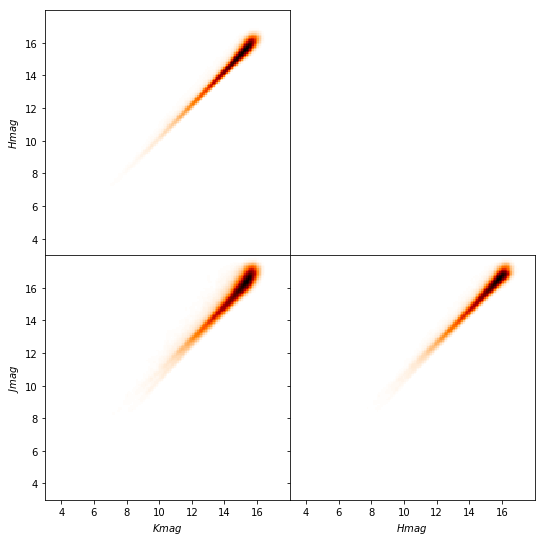

In [11]:
science.plot_combinations_kde()

We can do the same plot in color space with the instances created before:

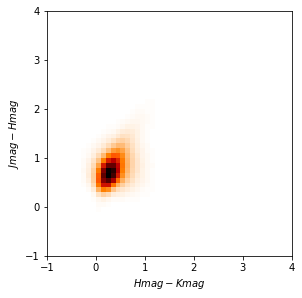

In [14]:
science.mag2color().plot_combinations_kde()

Also, it is very useful to look at the spatial distribution of sources. With the following plotting method we can display a kernel density map of all input features.

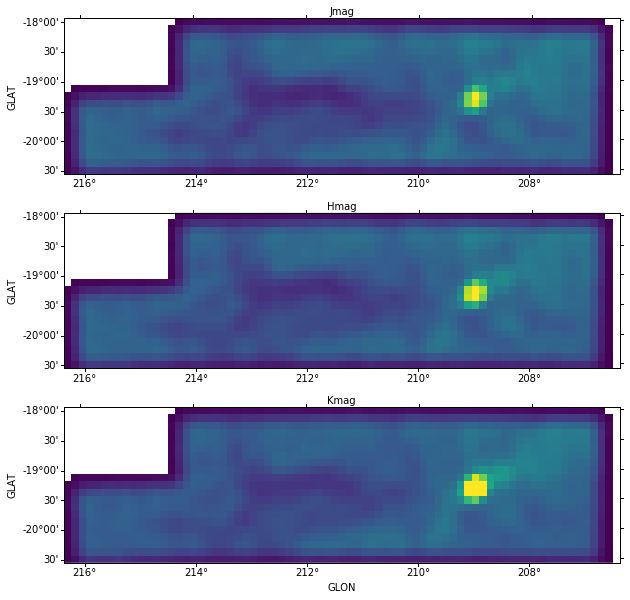

In [17]:
science.plot_sources_kde(bandwidth=15/60)

# Estimating extinction

Now that we had a look at our data, it is time to calculate the extinction. The software package offers both the new **PNICER** method, as well as a **NICER** implementation. Running them is very simple:

In [18]:
ext_pnicer = science_color.pnicer(control=control_color)

Or for **NICER**:

In [19]:
ext_nicer = science.nicer(control=control)

We must note a few things here:

+ **NICER** can only be run with an *ApparentMagnitudes* instance, since the individual photometric errors are used
+ **PNICER** can run on both *ApparentMagnitudes* and *ApparentColors* instances as long as you know the extinction vector for the components.
+ In our case, the extinction vector was normalized to 1 in K band. Thus, the results are directly given in A_K.

Furthermore, **PNICER** returns a probabilistic description of the extinction for each source and for the moment needs to be discretized to get useable values.

In [20]:
ext_pnicer_discrete = ext_pnicer.discretize()
ext_pnicer_discrete.extinction

array([ 0.00630463,  0.55273563, -0.19343433, ...,  0.04250305,
        0.3435255 ,  0.17846116], dtype=float32)

**NICER** returns discrete extinction by design

In [21]:
ext_nicer.extinction

array([ 0.0458285 ,  0.46716371, -0.19305522, ...,  0.04167068,
        0.30837865,  0.09102876])

Both calculations return and *Extinction* instance from which further options are available. We can save the data in a FITS table if we want:

In [22]:
ext_pnicer_discrete.save_fits(path="/tmp/temp.fits")

## Extinction map

The *Extinction* instance we got above can now also be used to calculate and extinction map. For this, various options are available

In [33]:
pnicer_emap = ext_pnicer_discrete.build_map(bandwidth=5 / 60, metric="gaussian", sampling=2, use_fwhm=True, nicest=True)

The methods above returns an *ExtinctionMap* instance, which again can be used for various subsequent tasks. We can save the data as a FITS image:

In [34]:
pnicer_emap.save_fits(path="/tmp/temp.fits")

Note that this already includes an automaically calculated astrometric projection. We can also display the results with a convenient plotting method:

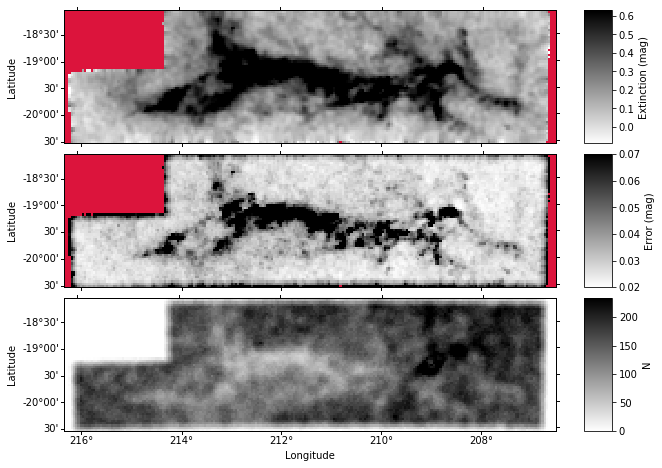

In [35]:
pnicer_emap.plot_map(figsize=10)

The red background here refers to pixels where not enough sources are available. These are the basics of **PNICER/NICER**. Happy hunting for extinction! :)